# Kunskapskontroll - Klassificera    ansiktsuttryck & Kön & Ålder

In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

# Importing Deep Learning Libraries
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from keras.models import load_model



2023-10-10 12:38:32.987959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/p8/v_x4r0f92rzbjyqy257wpsr40000gn/T/ipykernel_63461/1622261498.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
#Definerar hyperparameters
picture_size = 48
batch_size  = 128 #antal bildfiler som tar in på en iteration på träningsdatan
num_classes = 7 #antal klasser, finns 7 ansiktsutryck/emotion
epochs = 40 #träningsomgångar, antalet gånger som hela träningsdata används för att träna en modell
class_names = ['angry', 'disgust','fear', 'happy','neutral','sad','surprise']


#dirctories for emotion dataset

emotion_path = "/Users/farhana/Documents/DeepLearning/subset/"
emotion_validation_path = "/Users/farhana/Documents/DeepLearning/subset/validation/"
emotion_train_path = emotion_path+"/train/"

# EDA - exploratory data analysis

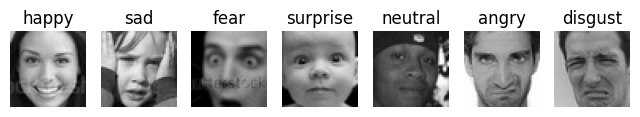

In [3]:
#exempelbilder på respektive expression. dataset består av 7 class dvs 7 stycken olika 
i=1
plt.figure(figsize=(8,8))
for expression in os.listdir(emotion_validation_path):
    img=load_img((emotion_validation_path+'/'+expression+'/'+os.listdir(emotion_validation_path+'/'+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i+=1

plt.show()

In [4]:
#antal data i varje mapp/ansiktsutryck i träningsmappen
for expression in os.listdir(emotion_train_path):
    print(expression,"klassen består\t\t",len(os.listdir(emotion_train_path+expression)),"images")

happy klassen består		 404 images
sad klassen består		 1075 images
fear klassen består		 1538 images
surprise klassen består		 1133 images
neutral klassen består		 2492 images
angry klassen består		 587 images
disgust klassen består		 335 images


In [5]:
#inblick på träningsdata
params=[]
for i in os.listdir(emotion_train_path):
    params.append(i)
    print(i,len(os.listdir(os.path.join(emotion_train_path,i))))

happy 404
sad 1075
fear 1538
surprise 1133
neutral 2492
angry 587
disgust 335


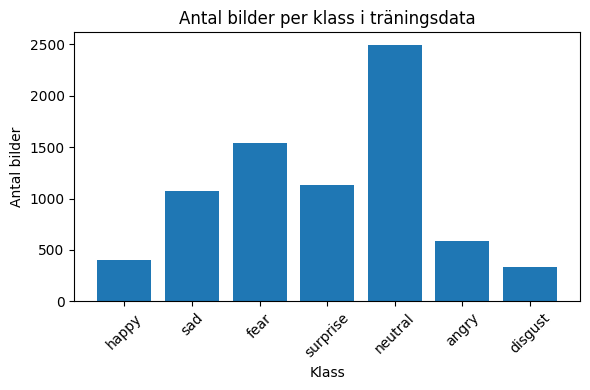

In [6]:
# Skapa listor för klasser och antal bilder
categories = []
num_images = []

# Loopa igenom mapparna och samla data
for i in os.listdir(emotion_train_path):
    category = i
    num = len(os.listdir(os.path.join(emotion_train_path, i)))
    
    categories.append(category)
    num_images.append(num)

# Skapa barchart
plt.figure(figsize=(6, 4))
plt.bar(categories, num_images)
plt.xlabel('Klass')
plt.ylabel('Antal bilder')
plt.title('Antal bilder per klass i träningsdata')
plt.xticks(rotation=45)  # Roterar x-axeln för att göra kategorierna mer läsbara
plt.tight_layout()

plt.show()

### Data Augmentation

Preprocess -  skapa tränings and validation data


In [7]:
# Data Augmentation - använder detta för att öka datamängden, alltså skapar fler att träna på utan att samla in mer data manuellt.
#Använder även för att förhindra overfitting och däremd bättre generalisering. Eftersom jag manuellt har tagit
#bort slumpmässig många data pga brist datorminne.

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=False,
                                   vertical_flip=False)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(emotion_train_path,
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = validation_datagen.flow_from_directory(emotion_validation_path,
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)


Found 7557 images belonging to 7 classes.
Found 3782 images belonging to 7 classes.


### Bas Modell - CNN Arkitektur

In [8]:
base_model = Sequential()

#1st CNN layer
base_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

#2nd CNN layer
base_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.1))

#3rd CNN layer
base_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.1))

#4th CNN layer
base_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.1))

#flatten
base_model.add(Flatten())
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(0.2))

base_model.add(Dense(num_classes, activation='softmax'))

base_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
#print(model.summary())

In [9]:
model_path = 'base_model.h5'
checkpointer = ModelCheckpoint(model_path, 
                               monitor = 'val_acc', 
                               verbose = 1, 
                               save_best_only = True, 
                               mode = 'max')


### Träna modellen 

In [10]:
history = base_model.fit(x=train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks = [checkpointer])


Epoch 1/40
59/59 [==============================] - 97s 2s/step - loss: 1.7622 - accuracy: 0.3202 - val_loss: 2.0446 - val_accuracy: 0.1915
Epoch 2/40
59/59 [==============================] - 82s 1s/step - loss: 1.7327 - accuracy: 0.3307 - val_loss: 1.9454 - val_accuracy: 0.1921
Epoch 3/40
59/59 [==============================] - 68s 1s/step - loss: 1.6866 - accuracy: 0.3616 - val_loss: 1.8643 - val_accuracy: 0.2328
Epoch 4/40
59/59 [==============================] - 68s 1s/step - loss: 1.6488 - accuracy: 0.3832 - val_loss: 2.0130 - val_accuracy: 0.2414
Epoch 5/40
59/59 [==============================] - 68s 1s/step - loss: 1.6331 - accuracy: 0.3881 - val_loss: 1.9979 - val_accuracy: 0.2408
Epoch 6/40
59/59 [==============================] - 68s 1s/step - loss: 1.6043 - accuracy: 0.4001 - val_loss: 1.9045 - val_accuracy: 0.2473
Epoch 7/40
59/59 [==============================] - 71s 1s/step - loss: 1.5836 - accuracy: 0.4100 - val_loss: 1.8308 - val_accuracy: 0.2726
Epoch 8/40
59/59 [==

In [13]:
base_model.save("emotion_model.h5")

/Users/farhana/opt/anaconda3/envs/test_demo/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


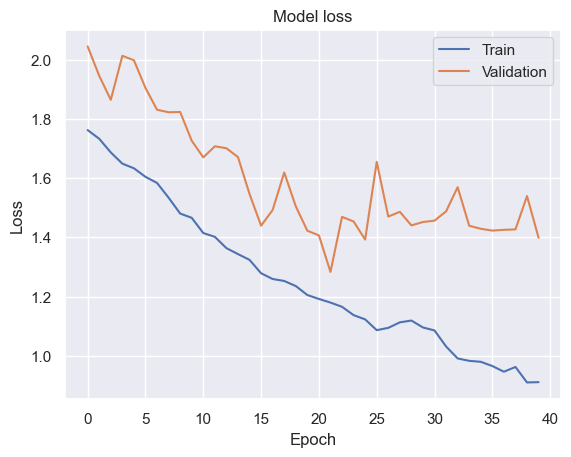

In [55]:
#Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Validation loss mäter hur bra modellen presterar på osett data. Under träningsfasen lär sig modellen att minimera loss funktion genom att uppdatera vikter. Loss funktion  beräknar skillnaden mellan den predikterade bilden/datan och den faktiska datan. Ju lägre förlusten är, desto bättre presterar modellen på träningsdata. I detta fall är modellens validation loss högre än träningens loss och därmed modellen overfittat. Även om vi använt oss av droupout och data augmentation. Idealt vill man validation loss lägre än traningsloss, för då vet man om modellen presterar bra på både tränings och valideringsdata. 

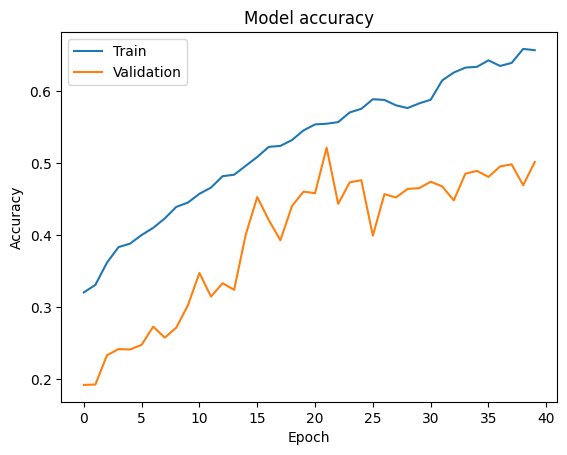

In [18]:
#jämför accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validation accuracy är accuracy hos en modell på nya data, medan training accuracy är accuracy hos en modell på den data den tränades på. Ofta är validation accuracy lägre än training accuracy eftersom modellen aldrig har sett valideringsdata tidigare. Ifall validation accuracy var högre än training accuracy skulle modellen var overfittat, men eftersom modellen har tillämpats droupout och data augmentation förhindras det och därmed bättre generaliseringsförmåga.

### CNN Arkitektur med BatchNormalization

Andra CNN modell med BatchNormalization vilket kan förbättra träningens stabilitet och konvergens.

In [19]:
model_2 = Sequential()

#1st CNN layer
model_2.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout(0.1))

#2nd CNN layer
model_2.add(Conv2D(128,(5,5),padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout (0.1))

#3rd CNN layer
model_2.add(Conv2D(512,(3,3),padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout (0.1))

#4th CNN layer
model_2.add(Conv2D(512,(3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.1))

model_2.add(Flatten())

#Fully connected 1st layer
model_2.add(Dense(256))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dropout(0.1))


# Fully connected layer 2nd layer
model_2.add(Dense(512))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dropout(0.1))

model_2.add(Dense(num_classes, activation='softmax'))

model_2.compile(optimizer=Adam(lr = 0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

In [20]:
#använder early stopping som regulariseringsteknik för att förhindra overfitting, alltså stoppa träningen 
#när vilkoren uppfyllts.
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,          
    restore_best_weights=True  # Restore model weights to the best iteration
)

### träna modell 

In [22]:
history_model2 = model_2.fit(x=train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks=[early_stopping])


Epoch 1/40
59/59 [==============================] - 260s 4s/step - loss: 1.8559 - accuracy: 0.3109 - val_loss: 2.1104 - val_accuracy: 0.0679
Epoch 2/40
59/59 [==============================] - 281s 5s/step - loss: 1.7254 - accuracy: 0.3505 - val_loss: 2.2852 - val_accuracy: 0.1915
Epoch 3/40
59/59 [==============================] - 282s 5s/step - loss: 1.6548 - accuracy: 0.3769 - val_loss: 2.4280 - val_accuracy: 0.0916
Epoch 4/40
59/59 [==============================] - 288s 5s/step - loss: 1.6012 - accuracy: 0.4014 - val_loss: 1.8981 - val_accuracy: 0.3033
Epoch 5/40
59/59 [==============================] - 263s 4s/step - loss: 1.5755 - accuracy: 0.4056 - val_loss: 2.2863 - val_accuracy: 0.1915
Epoch 6/40
59/59 [==============================] - 288s 5s/step - loss: 1.5128 - accuracy: 0.4286 - val_loss: 2.6621 - val_accuracy: 0.1422
Epoch 7/40
59/59 [==============================] - 305s 5s/step - loss: 1.4555 - accuracy: 0.4472 - val_loss: 2.5757 - val_accuracy: 0.2268
Epoch 8/40
59

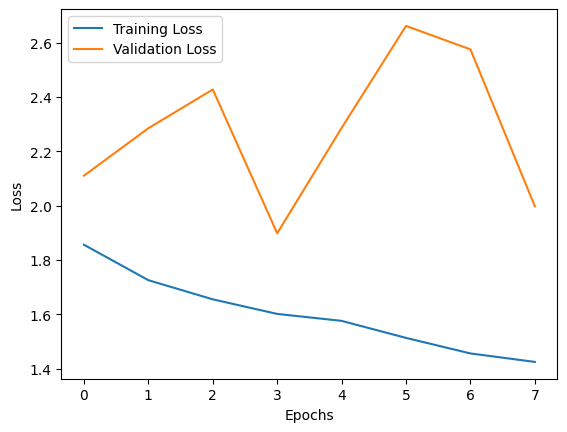

In [24]:
# jämför loss
plt.plot(history_model2.history['loss'], label='Training Loss')
plt.plot(history_model2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.legend()
plt.show()

In [25]:
history_1 = model_2.fit(x=train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size)

Epoch 1/40
59/59 [==============================] - 313s 5s/step - loss: 1.5441 - accuracy: 0.4235 - val_loss: 2.3451 - val_accuracy: 0.1915
Epoch 2/40
59/59 [==============================] - 310s 5s/step - loss: 1.5325 - accuracy: 0.4258 - val_loss: 2.1795 - val_accuracy: 0.1738
Epoch 3/40
59/59 [==============================] - 266s 5s/step - loss: 1.4508 - accuracy: 0.4476 - val_loss: 2.1596 - val_accuracy: 0.1851
Epoch 4/40
59/59 [==============================] - 206s 3s/step - loss: 1.4041 - accuracy: 0.4700 - val_loss: 1.9534 - val_accuracy: 0.2328
Epoch 5/40
59/59 [==============================] - 207s 4s/step - loss: 1.3452 - accuracy: 0.4874 - val_loss: 1.7942 - val_accuracy: 0.3599
Epoch 6/40
59/59 [==============================] - 205s 3s/step - loss: 1.3569 - accuracy: 0.4849 - val_loss: 1.7095 - val_accuracy: 0.3351
Epoch 7/40
59/59 [==============================] - 228s 4s/step - loss: 1.2942 - accuracy: 0.5063 - val_loss: 1.5708 - val_accuracy: 0.3839
Epoch 8/40
59

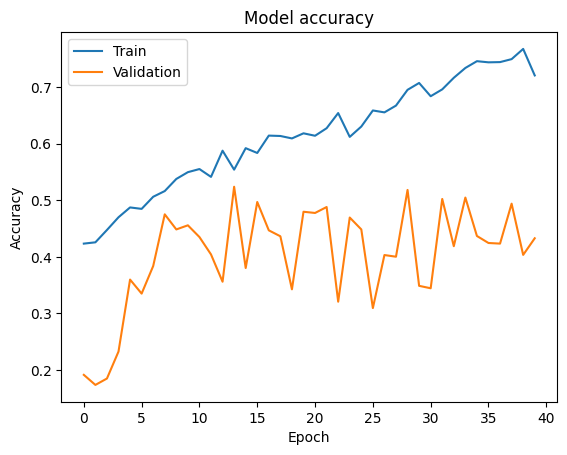

In [26]:
#Model accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


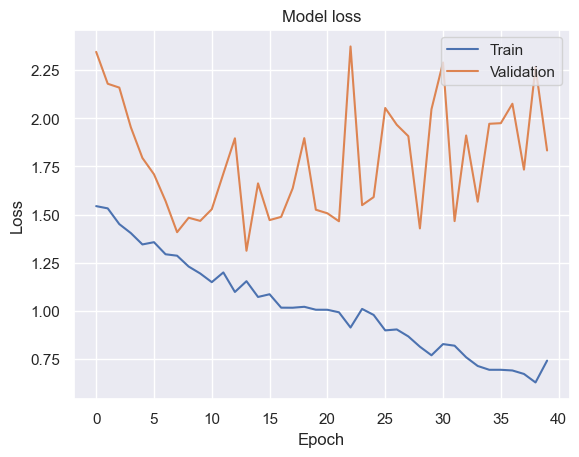

In [57]:
#Model loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Keras tuner

Väljer keras tuner bibliotek för tunning hyperparameter eftersom det sägs att det är effektivt sätt att söka efter den bästa hyperparametrar för att optimera ett neuralt nätverk modell.

In [32]:
def build_model(hp):
    model = Sequential()

    # lägg Convolutional layers
    model.add(Conv2D(
        filters=hp.Int('conv1_units', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(picture_size, picture_size, 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.20))

    model.add(Conv2D(
        filters=hp.Int('conv2_units', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.20))

    # Flatten modellen
    model.add(Flatten())

    # lägga till Dense layers
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [33]:
# skapa a tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, #antal försök att prova olika kombinationer av hyperparametrar
    directory='keras_tuning_dir', #tuner sparas sina resultat under mappen keras på samma directory
    project_name='cnn_kerastuning'
)

In [34]:
#översikt av de hyperparametrar som justeras och deras möjliga värden
tuner.search_space_summary()

Search space summary
Default search space size: 5
conv1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}


visa en sammanfattning av sökutrymmet. Denna sammanfattning ger information om hyperparametrarna och deras sökintervall eller val. Det hjälper dig att förstå vilka hyperparametrar som justeras och deras möjliga värden

In [35]:
#spara modellen med hjälp av ckeckpoint

checkpoint = ModelCheckpoint(filepath="model_kerastuner.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


In [37]:
# Söker efter bästa hyperparameter 
tuner.search(train_set, validation_data=test_set)

Trial 5 Complete [00h 00m 41s]
val_accuracy: 0.1879957765340805

Best val_accuracy So Far: 0.18905341625213623
Total elapsed time: 00h 38m 05s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [44]:
tuner.results_summary()

Results summary
Results in keras_tuning_dir/cnn_kerastuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
conv1_units: 128
conv1_kernel: 5
conv2_units: 32
conv2_kernel: 3
dense_units: 512
Score: 0.18905341625213623

Trial 1 summary
Hyperparameters:
conv1_units: 128
conv1_kernel: 5
conv2_units: 160
conv2_kernel: 3
dense_units: 320
Score: 0.18852458894252777

Trial 0 summary
Hyperparameters:
conv1_units: 128
conv1_kernel: 5
conv2_units: 192
conv2_kernel: 3
dense_units: 320
Score: 0.1879957765340805

Trial 4 summary
Hyperparameters:
conv1_units: 32
conv1_kernel: 5
conv2_units: 160
conv2_kernel: 3
dense_units: 512
Score: 0.1879957765340805

Trial 2 summary
Hyperparameters:
conv1_units: 96
conv1_kernel: 5
conv2_units: 256
conv2_kernel: 5
dense_units: 512
Traceback (most recent call last):
  File "/Users/farhana/opt/anaconda3/envs/test_demo/lib/python3.9/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_updat

presterade bäst och få insikter om vilka kombinationer av hyperparametrar som ledde till förbättrad modellprestanda. 

In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
#bygger modellen med de bästa hyperparametrar 
final_model = tuner.hypermodel.build(best_hps)

In [41]:
history_kerastuner = final_model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=50,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=[checkpoint])
                                               

Epoch 1/50


/var/folders/p8/v_x4r0f92rzbjyqy257wpsr40000gn/T/ipykernel_63461/128588985.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_kerastuner = final_model.fit_generator(generator=train_set,


59/59 [==============================] - ETA: 0s - loss: 1.7639 - accuracy: 0.3170WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 55s 893ms/step - loss: 1.7639 - accuracy: 0.3170 - val_loss: 1.9375 - val_accuracy: 0.1915
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 1.7273 - accuracy: 0.3393WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 50s 846ms/step - loss: 1.7273 - accuracy: 0.3393 - val_loss: 1.8804 - val_accuracy: 0.2613
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 1.6725 - accuracy: 0.3738WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 49s 833ms/step - loss: 1.6725 - accuracy: 0.3738 - val_loss: 1.8497 - val_accuracy: 0.2470
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 1.6531 - accuracy: 0.3815WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 816ms/step - loss: 1.6531 - accuracy: 0.3815 - val_loss: 1.9875 - val_accuracy: 0.2365
Epoch 5/50
59/59 [==============================] - ETA: 0s - loss: 1.6365 - accuracy: 0.3882WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 818ms/step - loss: 1.6365 - accuracy: 0.3882 - val_loss: 1.8908 - val_accuracy: 0.2422
Epoch 6/50
59/59 [==============================] - ETA: 0s - loss: 1.6315 - accuracy: 0.3875WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 811ms/step - loss: 1.6315 - accuracy: 0.3875 - val_loss: 1.8624 - val_accuracy: 0.2416
Epoch 7/50
59/59 [==============================] - ETA: 0s - loss: 1.6136 - accuracy: 0.3920WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 816ms/step - loss: 1.6136 - accuracy: 0.3920 - val_loss: 1.9884 - val_accuracy: 0.2411
Epoch 8/50
59/59 [==============================] - ETA: 0s - loss: 1.5946 - accuracy: 0.3951WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 817ms/step - loss: 1.5946 - accuracy: 0.3951 - val_loss: 1.8981 - val_accuracy: 0.2403
Epoch 9/50
59/59 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3967WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 814ms/step - loss: 1.6023 - accuracy: 0.3967 - val_loss: 1.8899 - val_accuracy: 0.2403
Epoch 10/50
59/59 [==============================] - ETA: 0s - loss: 1.5761 - accuracy: 0.4089WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 806ms/step - loss: 1.5761 - accuracy: 0.4089 - val_loss: 1.8178 - val_accuracy: 0.2584
Epoch 11/50
59/59 [==============================] - ETA: 0s - loss: 1.5623 - accuracy: 0.4134WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 49s 830ms/step - loss: 1.5623 - accuracy: 0.4134 - val_loss: 1.8541 - val_accuracy: 0.2584
Epoch 12/50
59/59 [==============================] - ETA: 0s - loss: 1.5420 - accuracy: 0.4211WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 806ms/step - loss: 1.5420 - accuracy: 0.4211 - val_loss: 1.7691 - val_accuracy: 0.2699
Epoch 13/50
59/59 [==============================] - ETA: 0s - loss: 1.5387 - accuracy: 0.4198WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 809ms/step - loss: 1.5387 - accuracy: 0.4198 - val_loss: 1.7498 - val_accuracy: 0.2697
Epoch 14/50
59/59 [==============================] - ETA: 0s - loss: 1.5052 - accuracy: 0.4326WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 808ms/step - loss: 1.5052 - accuracy: 0.4326 - val_loss: 1.8505 - val_accuracy: 0.2643
Epoch 15/50
59/59 [==============================] - ETA: 0s - loss: 1.5116 - accuracy: 0.4313WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 818ms/step - loss: 1.5116 - accuracy: 0.4313 - val_loss: 1.7800 - val_accuracy: 0.2869
Epoch 16/50
59/59 [==============================] - ETA: 0s - loss: 1.4937 - accuracy: 0.4317WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 811ms/step - loss: 1.4937 - accuracy: 0.4317 - val_loss: 1.7607 - val_accuracy: 0.2874
Epoch 17/50
59/59 [==============================] - ETA: 0s - loss: 1.4862 - accuracy: 0.4421WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 812ms/step - loss: 1.4862 - accuracy: 0.4421 - val_loss: 1.8190 - val_accuracy: 0.2842
Epoch 18/50
59/59 [==============================] - ETA: 0s - loss: 1.4650 - accuracy: 0.4446WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 787ms/step - loss: 1.4650 - accuracy: 0.4446 - val_loss: 1.6951 - val_accuracy: 0.3198
Epoch 19/50
59/59 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.4508WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 796ms/step - loss: 1.4501 - accuracy: 0.4508 - val_loss: 1.6675 - val_accuracy: 0.3389
Epoch 20/50
59/59 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.4519WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 787ms/step - loss: 1.4483 - accuracy: 0.4519 - val_loss: 1.7685 - val_accuracy: 0.3106
Epoch 21/50
59/59 [==============================] - ETA: 0s - loss: 1.4386 - accuracy: 0.4531WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 795ms/step - loss: 1.4386 - accuracy: 0.4531 - val_loss: 1.7286 - val_accuracy: 0.3023
Epoch 22/50
59/59 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.4636WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 801ms/step - loss: 1.4177 - accuracy: 0.4636 - val_loss: 1.6009 - val_accuracy: 0.3788
Epoch 23/50
59/59 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.4705WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 812ms/step - loss: 1.4013 - accuracy: 0.4705 - val_loss: 1.6237 - val_accuracy: 0.3685
Epoch 24/50
59/59 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.4807WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 782ms/step - loss: 1.3874 - accuracy: 0.4807 - val_loss: 1.6411 - val_accuracy: 0.3526
Epoch 25/50
59/59 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.4803WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 792ms/step - loss: 1.3811 - accuracy: 0.4803 - val_loss: 1.6664 - val_accuracy: 0.3529
Epoch 26/50
59/59 [==============================] - ETA: 0s - loss: 1.3593 - accuracy: 0.4839WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 803ms/step - loss: 1.3593 - accuracy: 0.4839 - val_loss: 1.5821 - val_accuracy: 0.3763
Epoch 27/50
59/59 [==============================] - ETA: 0s - loss: 1.3511 - accuracy: 0.4908WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 787ms/step - loss: 1.3511 - accuracy: 0.4908 - val_loss: 1.6409 - val_accuracy: 0.3718
Epoch 28/50
59/59 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.4881WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 784ms/step - loss: 1.3520 - accuracy: 0.4881 - val_loss: 1.6777 - val_accuracy: 0.3548
Epoch 29/50
59/59 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.4948WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 794ms/step - loss: 1.3410 - accuracy: 0.4948 - val_loss: 1.6079 - val_accuracy: 0.3645
Epoch 30/50
59/59 [==============================] - ETA: 0s - loss: 1.3567 - accuracy: 0.4923WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 789ms/step - loss: 1.3567 - accuracy: 0.4923 - val_loss: 1.6374 - val_accuracy: 0.3696
Epoch 31/50
59/59 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.5049WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 805ms/step - loss: 1.3038 - accuracy: 0.5049 - val_loss: 1.6257 - val_accuracy: 0.3879
Epoch 32/50
59/59 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5114WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 793ms/step - loss: 1.3033 - accuracy: 0.5114 - val_loss: 1.6915 - val_accuracy: 0.3712
Epoch 33/50
59/59 [==============================] - ETA: 0s - loss: 1.2976 - accuracy: 0.5184WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 791ms/step - loss: 1.2976 - accuracy: 0.5184 - val_loss: 1.5722 - val_accuracy: 0.3869
Epoch 34/50
59/59 [==============================] - ETA: 0s - loss: 1.2985 - accuracy: 0.5002WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 787ms/step - loss: 1.2985 - accuracy: 0.5002 - val_loss: 1.6959 - val_accuracy: 0.3499
Epoch 35/50
59/59 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.5233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 804ms/step - loss: 1.2668 - accuracy: 0.5233 - val_loss: 1.7102 - val_accuracy: 0.3642
Epoch 36/50
59/59 [==============================] - ETA: 0s - loss: 1.2723 - accuracy: 0.5225WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 794ms/step - loss: 1.2723 - accuracy: 0.5225 - val_loss: 1.5803 - val_accuracy: 0.3990
Epoch 37/50
59/59 [==============================] - ETA: 0s - loss: 1.2613 - accuracy: 0.5267WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 792ms/step - loss: 1.2613 - accuracy: 0.5267 - val_loss: 1.6596 - val_accuracy: 0.3745
Epoch 38/50
59/59 [==============================] - ETA: 0s - loss: 1.2416 - accuracy: 0.5365WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 789ms/step - loss: 1.2416 - accuracy: 0.5365 - val_loss: 1.6069 - val_accuracy: 0.3957
Epoch 39/50
59/59 [==============================] - ETA: 0s - loss: 1.2265 - accuracy: 0.5429WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 799ms/step - loss: 1.2265 - accuracy: 0.5429 - val_loss: 1.6743 - val_accuracy: 0.3742
Epoch 40/50
59/59 [==============================] - ETA: 0s - loss: 1.2398 - accuracy: 0.5369WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 788ms/step - loss: 1.2398 - accuracy: 0.5369 - val_loss: 1.5981 - val_accuracy: 0.4087
Epoch 41/50
59/59 [==============================] - ETA: 0s - loss: 1.2188 - accuracy: 0.5417WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 778ms/step - loss: 1.2188 - accuracy: 0.5417 - val_loss: 1.5994 - val_accuracy: 0.4114
Epoch 42/50
59/59 [==============================] - ETA: 0s - loss: 1.2083 - accuracy: 0.5524WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 797ms/step - loss: 1.2083 - accuracy: 0.5524 - val_loss: 1.6365 - val_accuracy: 0.3982
Epoch 43/50
59/59 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.5507WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 792ms/step - loss: 1.2028 - accuracy: 0.5507 - val_loss: 1.6267 - val_accuracy: 0.4038
Epoch 44/50
59/59 [==============================] - ETA: 0s - loss: 1.1805 - accuracy: 0.5596WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 788ms/step - loss: 1.1805 - accuracy: 0.5596 - val_loss: 1.6068 - val_accuracy: 0.4027
Epoch 45/50
59/59 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.5458WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 790ms/step - loss: 1.2141 - accuracy: 0.5458 - val_loss: 1.7065 - val_accuracy: 0.3863
Epoch 46/50
59/59 [==============================] - ETA: 0s - loss: 1.1890 - accuracy: 0.5598WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 48s 805ms/step - loss: 1.1890 - accuracy: 0.5598 - val_loss: 1.6237 - val_accuracy: 0.4149
Epoch 47/50
59/59 [==============================] - ETA: 0s - loss: 1.1752 - accuracy: 0.5579WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 787ms/step - loss: 1.1752 - accuracy: 0.5579 - val_loss: 1.6096 - val_accuracy: 0.4157
Epoch 48/50
59/59 [==============================] - ETA: 0s - loss: 1.1619 - accuracy: 0.5620WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 46s 777ms/step - loss: 1.1619 - accuracy: 0.5620 - val_loss: 1.6175 - val_accuracy: 0.4092
Epoch 49/50
59/59 [==============================] - ETA: 0s - loss: 1.1638 - accuracy: 0.5637WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 789ms/step - loss: 1.1638 - accuracy: 0.5637 - val_loss: 1.6498 - val_accuracy: 0.4003
Epoch 50/50
59/59 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.5806WARNING:tensorflow:Can save best model only with val_acc available, skipping.


59/59 [==============================] - 47s 792ms/step - loss: 1.1307 - accuracy: 0.5806 - val_loss: 1.6697 - val_accuracy: 0.4065


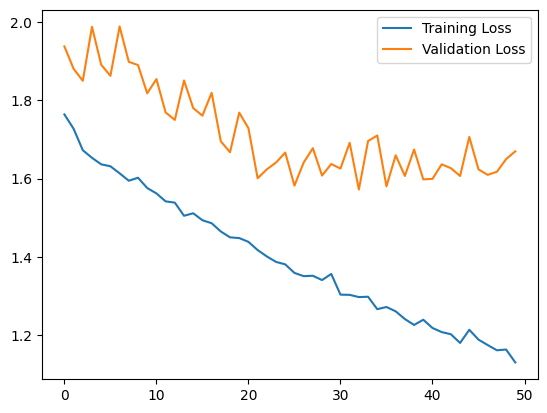

In [42]:
# jämför loss
plt.plot(history_kerastuner.history['loss'], label='Training Loss')
plt.plot(history_kerastuner.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

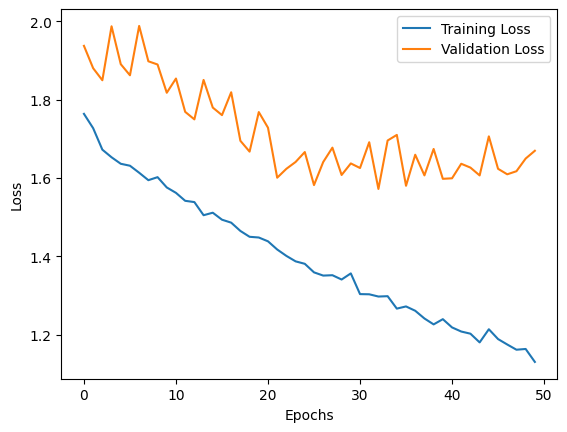

In [45]:
# jämför loss
plt.plot(history_kerastuner.history['loss'], label='Training Loss')
plt.plot(history_kerastuner.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Namn på x-axeln
plt.ylabel('Loss')  
plt.legend()
plt.show()

30/30 [==============================] - 10s 319ms/step


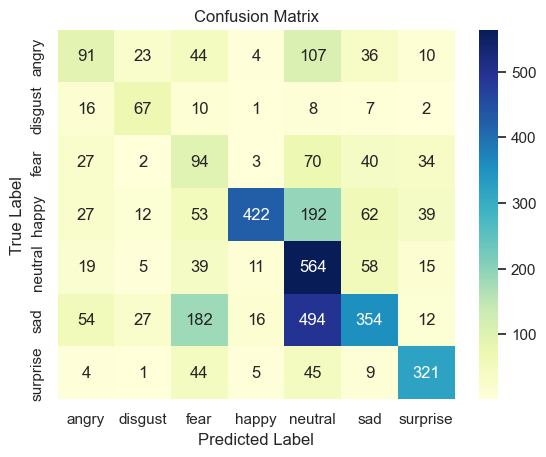

In [48]:
# Confusion Matrix på basmodellen

# Get the true labels and predicted labels for the validation set
validation_labels = test_set.classes
validation_pred_probs = base_model.predict(test_set)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_set.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Realtime detection - ansiktsutryck, kön och ålder

### Testa sparade modell med OpenCV


obs! gender och age CNN modeller har hörts på kaggle pga brist på datorminne

In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

emotion_model = load_model(r'emotion_model.h5')
age_model = load_model('age_model.h5')
gender_model = load_model('gender_model.h5')


class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
gender_labels = ['Female', 'Male']


cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    labels = []

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        # Get image ready for prediction
        roi = roi_gray.astype('float') / 255.0  # Scale
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)  

        preds = emotion_model.predict(roi)[0]  
        label = class_labels[preds.argmax()]  # Find the label
        label_position = (x, y)
        cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
         #Gender
        roi_color=frame[y:y+h,x:x+w]
        roi_color=cv2.resize(roi_color,(200,200),interpolation=cv2.INTER_AREA)
        gender_predict = gender_model.predict(np.array(roi_color).reshape(-1,200,200,3))
        gender_predict = (gender_predict>= 0.5).astype(int)[:,0]
        gender_label=gender_labels[gender_predict[0]] 
        gender_label_position=(x,y+h+50) 
        cv2.putText(frame,gender_label,gender_label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

        # Age
        roi_color = frame[y:y + h, x:x + w]
        age_predict = age_model.predict(np.array(cv2.resize(roi_color, (200, 200))).reshape(-1, 200, 200, 3))
        age = round(age_predict[0, 0])
        age_label_position = (x + h, y + h)
        cv2.putText(frame, "Age=" + str(age), age_label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        

    cv2.imshow('Emotion and Age and Gender Detector', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
